In [22]:
import re
import random
import pandas as pd
import hashlib

In [23]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [24]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
TSQL,80.665430,3.361060,8.614264,24
Finance Junk,162.219684,40.554921,67.252542,4
"Jane Eyre, Bronte",174.807980,21.850997,34.794642,8
Email Auth and Security,274.518869,45.753145,103.891721,6
Azure AD Authentication,528.632782,44.052732,113.510566,12
Logging in Python,579.577536,41.398395,79.220398,14
RAG Project,849.209314,84.920931,228.831218,10
Debugging in VS Code,1009.052279,91.732025,226.775673,11
Azure Private DNS,1113.223750,58.590724,124.498148,19
C# Basics,1392.303620,44.913020,117.188642,31


# Histogram

sum of ages: ~39250.90


<Axes: >

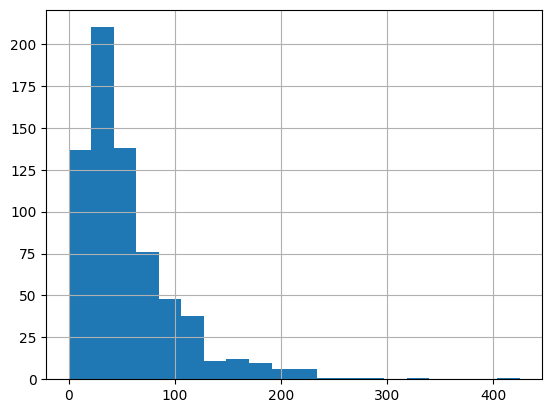

In [25]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~39250.90


<Axes: >

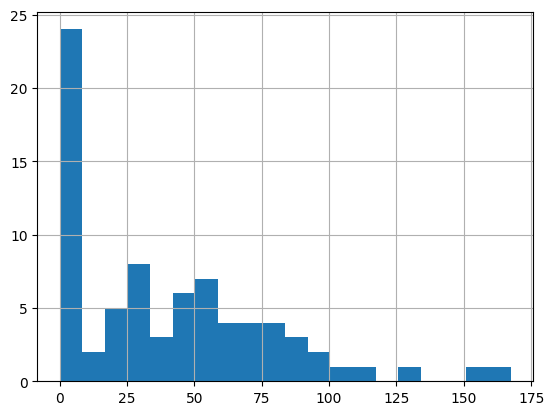

In [26]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [27]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [28]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [29]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [30]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [31]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [32]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [33]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [ ]:
n=3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


## Age Mean

In [ ]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

Cards found: 697
Total card age: 39250.90


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
200,Debugging in VS Code,Hot Reloading\nA feature in some debuggers and...,4f1abec2cf3c58532351639c4f24b9d2,-226.775673,-91.732025,226.775673,1009.052279,0.456928,0,0
201,Debugging in VS Code,Stack Trace\nA report that provides detailed i...,91024be8d7cdc8436214e3118e616d00,-99.127008,-91.732025,226.775673,1009.052279,0.456928,3,0
202,Debugging in VS Code,Symbolic Debugging\nA debugging technique that...,a53c593510a948b775f13ab92720ad3e,-58.173374,-91.732025,226.775673,1009.052279,0.456928,6,0
203,Debugging in VS Code,Profiling\nThe process of analyzing the perfor...,a49cdac6fb309645738191b10c39d124,-18.526196,-91.732025,226.775673,1009.052279,0.456928,9,0
204,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,-228.831218,-84.920931,228.831218,849.209314,0.381623,0,0
205,RAG Project,ASGI\nAsynchronous Server Gateway Interface — ...,8ba468f63a8eb59587a20b767f0fdf5e,-85.319335,-84.920931,228.831218,849.209314,0.381623,3,0
206,RAG Project,Object ID (OID)\nUnique identifier for a user ...,457db37b12bdb9edd5c82054473c76ed,-36.542888,-84.920931,228.831218,849.209314,0.381623,6,0
207,RAG Project,auth_client\nA special fixture often defined i...,6f737b87b759709e2365a5d4597982c2,-21.779623,-84.920931,228.831218,849.209314,0.381623,9,0
106,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,-256.083245,-82.181848,256.083245,2629.819150,0.388648,0,0
560,Python,How can you compare two Path objects for equal...,035f02d95c84e3abeaaf924efaa9a3a4,-179.264378,-82.181848,256.083245,2629.819150,0.388648,3,0


## Age Max

In [36]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [37]:
# n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [38]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [39]:
existing_cards.sort_values('age', ascending=True).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
15,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,-425.010358,-78.684363,425.010358,3619.480689,0.489040,0,0
79,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,-328.309770,-78.838020,328.309770,2917.006757,0.588623,0,0
167,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,-288.017580,-68.616411,288.017580,1646.793861,0.896507,0,0
106,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,-256.083245,-82.181848,256.083245,2629.819150,0.388648,0,0
60,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,-247.324162,-57.426852,247.324162,3158.476837,0.759912,0,0
158,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,-229.831824,-72.195046,229.831824,1877.071190,0.259453,0,0
204,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,-228.831218,-84.920931,228.831218,849.209314,0.381623,0,0
200,Debugging in VS Code,Hot Reloading\nA feature in some debuggers and...,4f1abec2cf3c58532351639c4f24b9d2,-226.775673,-91.732025,226.775673,1009.052279,0.456928,0,0
92,JavaScript Concepts,"Heroku: A cloud platform for deploying, managi...",81c33c8653348fa2529f220a4a2e60b1,-223.603483,-66.527456,223.603483,2727.625689,0.607136,0,0
430,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,-222.999763,-84.920931,228.831218,849.209314,0.381623,1,1


In [40]:
existing_cards.head(10).sum()

head                   Debugging in VS CodeDebugging in VS CodeDebugg...
body                   Hot Reloading\nA feature in some debuggers and...
hash                   4f1abec2cf3c58532351639c4f24b9d291024be8d7cdc8...
age                                                         -1210.422938
subject_mean_age                                             -870.975524
subject_highest_age                                          2334.594056
subject_age_sum                                             12692.684673
head_random_roll                                                4.131498
count                                                                 39
n_fold                                                                 0
dtype: object

In [41]:
existing_cards['age'].mean()

-56.31405594233831